## Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from scipy.io import loadmat
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, RocCurveDisplay

In [ ]:
mat_data = loadmat('/content/drive/MyDrive/IC/dadosatributos.mat')
dados_matlab = mat_data['Classificacao_atributos_multiclasse_Pot']

colunas = [
    'RMS', 'THD', 'Ondulacao', 'Curtose', 'Integral', 'R2Espelho', 'Entropia',
    'Harmonico1', 'Harmonico2', 'Harmonico3', 'Harmonico4', 'Harmonico5',
    'Harmonico6', 'Harmonico7', 'Harmonico8', 'Harmonico9', 'Harmonico10',
    'Harmonico11', 'Harmonico12', 'Harmonico13', 'Harmonico14', 'Harmonico15',
    'SNR', 'SFDR', 'pentropy', 'pkurtosis', 'pwelch', 'classe'
]

df = pd.DataFrame(dados_matlab, columns=colunas)
data = df.drop(columns=['Entropia', 'Harmonico1']) #Já que os dados de entropia e o primeiro harmonico são 0, eu retirei os dois atributos

In [ ]:
data.head()

,RMS,THD,Ondulacao,Curtose,Integral,R2Espelho,Harmonico2,Harmonico3,Harmonico4,Harmonico5,...,Harmonico12,Harmonico13,Harmonico14,Harmonico15,SNR,SFDR,pentropy,pkurtosis,pwelch,classe
0,275.947190,-8.347991,0.367449,2.282854,1.377499e+08,4.440892e-16,360.39928,29.89994,720.79856,360.299280,...,1435.897131,360.599280,120.099760,240.299520,6.386211,7.792834,149.144583,-356.040075,1.096853e+09,0.0
1,275.222373,-8.077195,0.327361,2.105086,1.374198e+08,4.440892e-16,360.39928,360.29928,360.49928,29.899940,...,720.998559,360.699279,720.498560,360.099281,8.467176,8.095529,149.138663,-363.762453,1.090012e+09,0.0
2,273.976093,-8.841217,0.356098,2.243326,1.368163e+08,0.000000e+00,360.39928,29.89994,720.79856,360.299280,...,60.099880,360.599280,360.099281,720.598560,7.472892,8.854985,148.976135,-22.641517,1.080985e+09,0.0
3,273.934680,-8.616354,0.340439,2.223688,1.367752e+08,0.000000e+00,360.49928,360.39928,720.89856,29.899940,...,720.998559,360.799279,120.199760,360.099281,8.317411,8.632286,149.136582,-362.034458,1.080237e+09,0.0
4,273.115952,-8.160949,0.350500,2.262253,1.363728e+08,4.440892e-16,360.19928,360.29928,29.89994,360.099281,...,720.298561,120.099760,359.999281,720.698560,8.188123,8.175723,149.095936,-427.404580,1.073395e+09,0.0


## Normalização e separação das váriaveis

In [ ]:
def cfs_feature_selection(X, y):

    corr_matrix = X.corr()
    mutual_info = mutual_info_classif(X, y, discrete_features='auto')

    mutual_info_df = pd.DataFrame(mutual_info, index=X.columns, columns=['Mutual Information'])


    selected_features = []
    for feature in X.columns:

        if feature not in selected_features:
            correlation_sum = sum(abs(corr_matrix[feature][selected]) for selected in selected_features)
            # Critério de seleção CFS (ajuste conforme necessário)
            if mutual_info_df.loc[feature, 'Mutual Information'] > correlation_sum:
                selected_features.append(feature)

    return selected_features

In [ ]:
X = data.drop(columns=['classe'])
y = data['classe']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
scaler = MinMaxScaler()
X_trainN = scaler.fit_transform(X_train)
X_testN = scaler.transform(X_test)

In [ ]:
selected_features = cfs_feature_selection(X_train, y_train)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("Atributos selecionados:", selected_features)

Atributos selecionados: ['RMS', 'Curtose', 'Integral', 'Harmonico10', 'Harmonico11', 'pkurtosis']


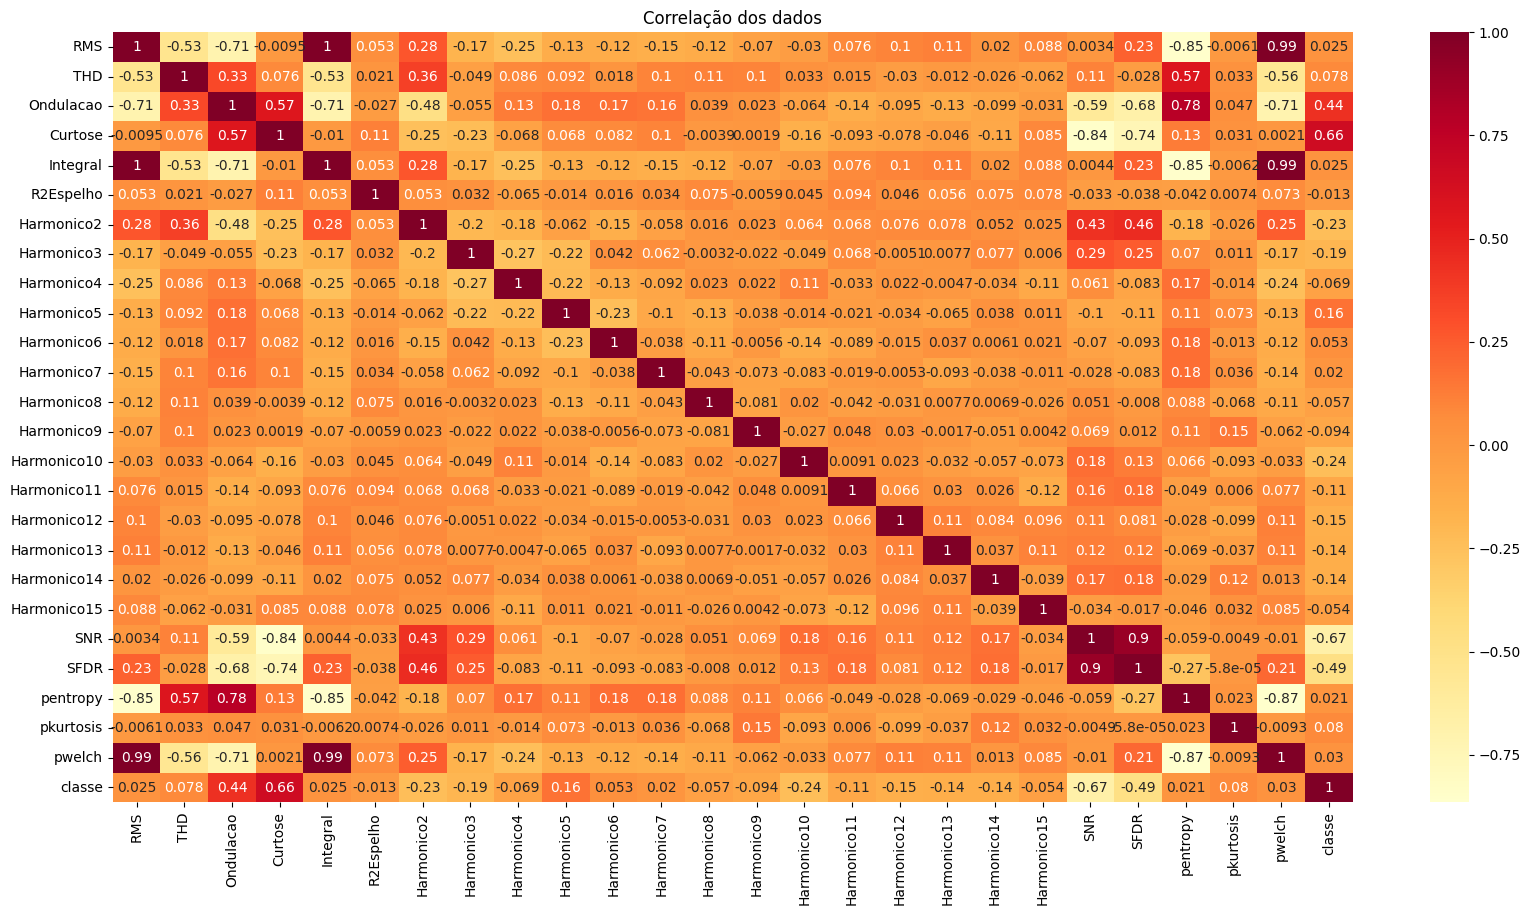

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True, cmap='YlOrRd')
plt.title("Correlação dos dados")
plt.show()

#Decision Tree - Árvores de decisões

In [ ]:
parametros = {
    'max_depth': [5, 7, 10, 15],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [5, 7, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', 0.6, 0.8],
    'class_weight': [None, 'balanced'],
    'ccp_alpha': [0.001, 0.01],
}
cv_tree = KFold(n_splits=10, shuffle=True, random_state=42)

random_search_tree = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    parametros,
    cv=cv_tree,
    n_jobs=-1,
    verbose=2
)

random_search_tree_normalizado = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    parametros,
    cv=cv_tree,
    n_jobs=-1,
    verbose=2
)

random_search_tree_selected = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    parametros,
    cv=cv_tree,
    n_jobs=-1,
    verbose=2
)

NameError: name 'KFold' is not defined

In [ ]:
random_search_tree.fit(X_train, y_train)

In [ ]:
random_search_tree_normalizado.fit(X_trainN, y_train)

In [ ]:
random_search_tree_selected.fit(X_train_selected, y_train)

In [ ]:
print("Melhores parâmetros:", random_search_tree.best_params_)
print("Melhor score (validação cruzada):", random_search_tree.best_score_)

In [ ]:
print("Melhores parâmetros com normalização:", random_search_tree_normalizado.best_params_)
print("Melhor score (validação cruzada) com normalização:", random_search_tree_normalizado.best_score_)

In [ ]:
print("Melhores parâmetros com atributos selecionados:", random_search_tree_selected.best_params_)
print("Melhor score (validação cruzada) com atributos selecionados:", random_search_tree_selected.best_score_)

In [ ]:
best_tree = random_search_tree.best_estimator_
best_tree_normalizado = random_search_tree_normalizado.best_estimator_
best_tree_selected = random_search_tree_selected.best_estimator_

best_tree.fit(X_train, y_train)
best_tree_normalizado.fit(X_trainN, y_train)
best_tree_selected.fit(X_train_selected, y_train)

In [ ]:
y_pred_tree = best_tree.predict(X_test)
y_pred_train_tree = best_tree.predict(X_train)

In [ ]:
y_pred_tree_normalizado = best_tree_normalizado.predict(X_testN)
y_pred_train_tree_normalizado = best_tree_normalizado.predict(X_trainN)

In [ ]:
y_pred_tree_selected = best_tree_selected.predict(X_test_selected)
y_pred_train_tree_selected = best_tree_selected.predict(X_train_selected)

# Dados sem aplicar a normalização

In [ ]:
print("Acurácia de treino:", accuracy_score(y_train, y_pred_train_tree))
print("Acurácia de teste:", accuracy_score(y_test, y_pred_tree))
print("F1 Score de teste:", f1_score(y_test, y_pred_tree, average='weighted'))
print("Precisão de teste:", precision_score(y_test, y_pred_tree, average='weighted'))
print("Recall de teste:", recall_score(y_test, y_pred_tree, average='weighted'))
print(classification_report(y_test, y_pred_tree))

Acurácia de treino: 0.746875
Acurácia de teste: 0.625
F1 Score de teste: 0.6171212771212772
Precisão de teste: 0.6300369908729042
Recall de teste: 0.625
              precision    recall  f1-score   support

         0.0       0.71      0.94      0.81        16
         1.0       0.47      0.50      0.48        16
         2.0       0.64      0.44      0.52        16
         3.0       0.58      0.69      0.63        16
         4.0       0.75      0.56      0.64        16

    accuracy                           0.62        80
   macro avg       0.63      0.62      0.62        80
weighted avg       0.63      0.62      0.62        80



# Dados Normalizados

In [ ]:
print("Acurácia de treino dados normalizados:", accuracy_score(y_train, y_pred_train_tree_normalizado))
print("Acurácia de teste dados normalizado:", accuracy_score(y_test, y_pred_tree_normalizado))
print("F1 Score de teste dados normalizados:", f1_score(y_test, y_pred_tree_normalizado, average='weighted'))
print("Precisão de teste dados normalizados:", precision_score(y_test, y_pred_tree_normalizado, average='weighted'))
print("Recall de teste dados normalizados:", recall_score(y_test, y_pred_tree_normalizado, average='weighted'))
print(classification_report(y_test, y_pred_tree))

Acurácia de treino dados normalizados: 0.83125
Acurácia de teste dados normalizado: 0.725
F1 Score de teste dados normalizados: 0.7131057703471497
Precisão de teste dados normalizados: 0.7188410660546884
Recall de teste dados normalizados: 0.725
              precision    recall  f1-score   support

         0.0       0.71      0.94      0.81        16
         1.0       0.47      0.50      0.48        16
         2.0       0.64      0.44      0.52        16
         3.0       0.58      0.69      0.63        16
         4.0       0.75      0.56      0.64        16

    accuracy                           0.62        80
   macro avg       0.63      0.62      0.62        80
weighted avg       0.63      0.62      0.62        80



# Dados com atributos selecionados

In [ ]:
print("Acurácia de treino dados selecionados:", accuracy_score(y_train, y_pred_train_tree_selected))
print("Acurácia de teste dados selecionados:", accuracy_score(y_test, y_pred_tree_selected))
print("F1 Score de teste dados selecionados:", f1_score(y_test, y_pred_tree_selected, average='weighted'))
print("Precisão de teste dados selecionados:", precision_score(y_test, y_pred_tree_selected, average='weighted'))
print("Recall de teste dados selecionados:", recall_score(y_test, y_pred_tree_selected, average='weighted'))

Acurácia de treino dados selecionados: 0.6125
Acurácia de teste dados selecionados: 0.575
F1 Score de teste dados selecionados: 0.5340864127035918
Precisão de teste dados selecionados: 0.5895435139573071
Recall de teste dados selecionados: 0.575


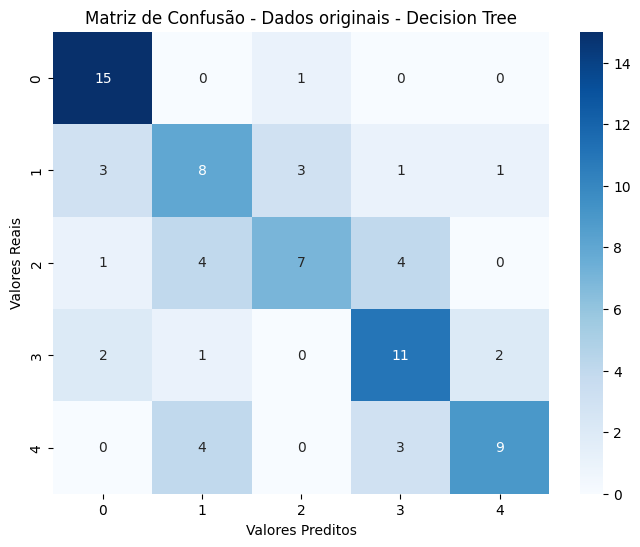

In [ ]:
cm_tree = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Dados originais - Decision Tree')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

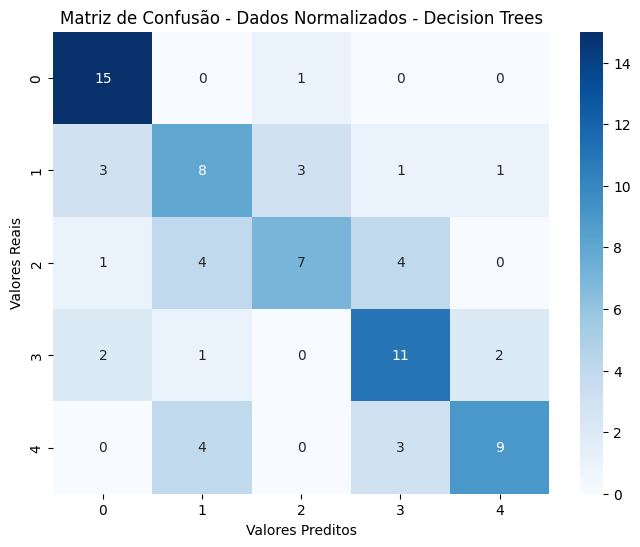

In [ ]:
cm_tree_normalizado = confusion_matrix(y_test, y_pred_tree_normalizado)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Dados Normalizados - Decision Trees')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

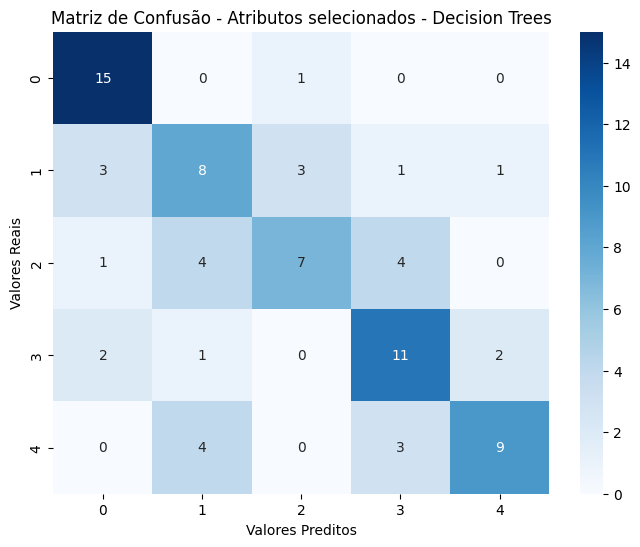

In [ ]:
cm_tree_selected = confusion_matrix(y_test, y_pred_tree_selected)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Atributos selecionados - Decision Trees')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

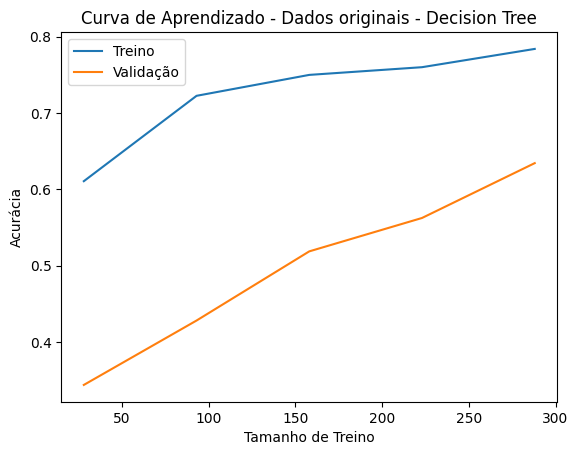

In [ ]:
train_sizes_DT, train_scores_DT, test_scores_DT = learning_curve(best_tree, X_train, y_train, cv=cv_tree)

plt.plot(train_sizes_DT, np.mean(train_scores_DT, axis=1), label='Treino')
plt.plot(train_sizes_DT, np.mean(test_scores_DT, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Dados originais - Decision Tree')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

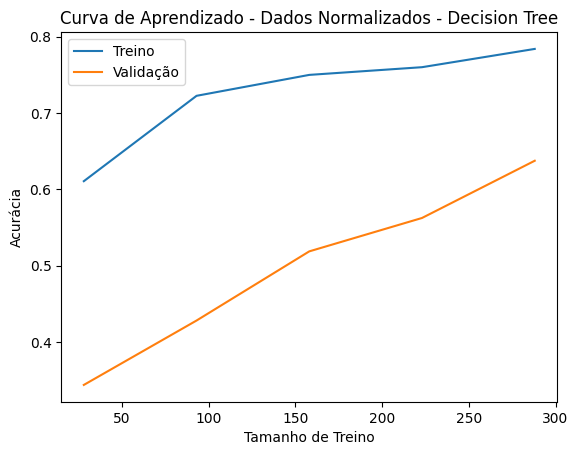

In [ ]:
train_sizes_DT_norm, train_scores_DT_norm, test_scores_DT_norm = learning_curve(best_tree, X_trainN, y_train, cv=cv_tree)

plt.plot(train_sizes_DT_norm, np.mean(train_scores_DT_norm, axis=1), label='Treino')
plt.plot(train_sizes_DT_norm, np.mean(test_scores_DT_norm, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Dados Normalizados - Decision Tree')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

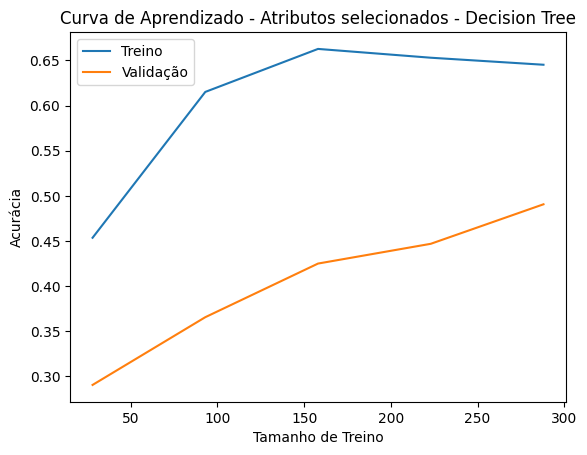

In [ ]:
train_sizes_DT_selected, train_scores_DT_selected, test_scores_DT_selected = learning_curve(best_tree, X_train_selected, y_train, cv=cv_tree)

plt.plot(train_sizes_DT_selected, np.mean(train_scores_DT_selected, axis=1), label='Treino')
plt.plot(train_sizes_DT_selected, np.mean(test_scores_DT_selected, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Atributos selecionados - Decision Tree')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

## SVM  - Support Vector Machine

In [ ]:
pipeline_svm = Pipeline([
    ('svc', SVC(probability=False, cache_size=2000, random_state=42))])

param_dist = {
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1],
    'svc__kernel': ['rbf'],
}

cv_svm = KFold(n_splits=10, shuffle=True, random_state=42)

random_search_svm= RandomizedSearchCV(
    pipeline_svm,
    param_dist,
    refit=True,
    cv = cv_svm,
    # n_jobs=-1,
    verbose=2,
)

random_search_svm_normalizado= RandomizedSearchCV(
    pipeline_svm,
    param_dist,
    refit=True,
    cv = cv_svm,
    # n_jobs=-1,
    verbose=2,
  )

random_search_svm_selected= RandomizedSearchCV(
    pipeline_svm,
    param_dist,
    refit=True,
    cv = cv_svm,
    # n_jobs=-1,
    verbose=2,
  )

In [ ]:
random_search_svm.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END .......svc__C=0.01, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END .......svc__C=0.01, svc__gamma=0.1, s

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('svc',
                                              SVC(cache_size=2000,
                                                  random_state=42))]),
                   param_distributions={'svc__C': [0.01, 0.1, 1, 10, 100],
                                        'svc__gamma': [0.001, 0.01, 0.1],
                                        'svc__kernel': ['rbf']},
                   verbose=2)

In [ ]:
random_search_svm_normalizado.fit(X_trainN, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END .......svc__C=0.01, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END .......svc__C=0.01, svc__gamma=0.1, s

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('svc',
                                              SVC(cache_size=2000,
                                                  random_state=42))]),
                   param_distributions={'svc__C': [0.01, 0.1, 1, 10, 100],
                                        'svc__gamma': [0.001, 0.01, 0.1],
                                        'svc__kernel': ['rbf']},
                   verbose=2)

In [ ]:
random_search_svm_selected.fit(X_train_selected, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .....svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.001, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.01, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.01, svc__gamma=0.01, s

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('svc',
                                              SVC(cache_size=2000,
                                                  random_state=42))]),
                   param_distributions={'svc__C': [0.01, 0.1, 1, 10, 100],
                                        'svc__gamma': [0.001, 0.01, 0.1],
                                        'svc__kernel': ['rbf']},
                   verbose=2)

In [ ]:
print("Melhores parâmetros:", random_search_svm.best_params_)
print("Melhor score (validação cruzada):", random_search_svm.best_score_)

Melhores parâmetros: {'svc__kernel': 'rbf', 'svc__gamma': 0.1, 'svc__C': 1}
Melhor score (validação cruzada): 0.1125


In [ ]:
print("Melhores parâmetros com normalização:", random_search_svm_normalizado.best_params_)
print("Melhor score (validação cruzada) com normalização:", random_search_svm_normalizado.best_score_)

Melhores parâmetros com normalização: {'svc__kernel': 'rbf', 'svc__gamma': 0.1, 'svc__C': 100}
Melhor score (validação cruzada) com normalização: 0.734375


In [ ]:
print("Melhores parâmetros com atributos selecionados:", random_search_svm_selected.best_params_)
print("Melhor score (validação cruzada) com atributos selecionados:", random_search_svm_selected.best_score_)

Melhores parâmetros com atributos selecionados: {'svc__kernel': 'rbf', 'svc__gamma': 0.1, 'svc__C': 100}
Melhor score (validação cruzada) com atributos selecionados: 0.1125


In [ ]:
best_svc = random_search_svm.best_estimator_
best_svc.fit(X_train, y_train)
y_pred_svc = best_svc.predict(X_test)
y_train_svc = best_svc.predict(X_train)

In [ ]:
best_svc_normalizado = random_search_svm_normalizado.best_estimator_
best_svc_normalizado.fit(X_trainN, y_train)
y_pred_svc_normalizado = best_svc_normalizado.predict(X_testN)
y_train_svc_normalizado = best_svc_normalizado.predict(X_trainN)

In [ ]:
best_svc_selected = random_search_svm_selected.best_estimator_
best_svc_selected.fit(X_train_selected, y_train)
y_pred_svc_selected = best_svc_selected.predict(X_test_selected)
y_train_svc_selected = best_svc_selected.predict(X_train_selected)

# Dados sem normalização

In [ ]:
print("Acurácia de treino SVM:", accuracy_score(y_train, y_train_svc))
print("Acurácia de teste SVM:",accuracy_score(y_test, best_svc.predict(X_testN)))
print("F1 Score de teste SVM:", f1_score(y_test, y_pred_svc, average='weighted'))
print("Precisão de teste SVM:", precision_score(y_test, y_pred_svc, average='weighted'))
print("Recall de teste SVM:", recall_score(y_test, y_pred_svc, average='weighted'))
print(classification_report(y_test, y_pred_svc))

Acurácia de treino SVM: 1.0
Acurácia de teste SVM: 0.2
F1 Score de teste SVM: 0.06666666666666667
Precisão de teste SVM: 0.04
Recall de teste SVM: 0.2
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        16
         2.0       0.00      0.00      0.00        16
         3.0       0.00      0.00      0.00        16
         4.0       0.20      1.00      0.33        16

    accuracy                           0.20        80
   macro avg       0.04      0.20      0.07        80
weighted avg       0.04      0.20      0.07        80



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

# Dados normalizados

In [ ]:
print("Acurácia de treino SVM, dados normalizados:", accuracy_score(y_train, y_train_svc_normalizado))
print("Acurácia de teste SVM, dados normalizados:",accuracy_score(y_test, best_svc_normalizado.predict(X_testN)))
print("F1 Score de teste SVM , dados normalizados:", f1_score(y_test, y_pred_svc_normalizado, average='weighted'))
print("Precisão de teste SVM, dados normalizados:", precision_score(y_test, y_pred_svc_normalizado, average='weighted'))
print("Recall de teste SVM, dados normalizados:", recall_score(y_test, y_pred_svc_normalizado, average='weighted'))
print(classification_report(y_test, y_pred_svc_normalizado))

NameError: name 'accuracy_score' is not defined

# Dados com atributos selecionados

In [ ]:
print("Acurácia de treino SVM, atributos selecionados:", accuracy_score(y_train, y_train_svc_selected))
print("Acurácia de teste SVM, atributos selecionados:",accuracy_score(y_test, best_svc_selected.predict(X_test_selected)))
print("F1 Score de teste SVM, atributos selecionados:", f1_score(y_test, y_pred_svc_selected, average='weighted'))
print("Precisão de teste SVM, atributos selecionados:", precision_score(y_test, y_pred_svc_selected, average='weighted'))
print("Recall de teste SVM, atributos selecionados:", recall_score(y_test, y_pred_svc_selected, average='weighted'))
print(classification_report(y_test, y_pred_svc_selected))

Acurácia de treino SVM, atributos selecionados: 1.0
Acurácia de teste SVM, atributos selecionados: 0.2
F1 Score de teste SVM, atributos selecionados: 0.06666666666666667
Precisão de teste SVM, atributos selecionados: 0.04
Recall de teste SVM, atributos selecionados: 0.2
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        16
         2.0       0.00      0.00      0.00        16
         3.0       0.00      0.00      0.00        16
         4.0       0.20      1.00      0.33        16

    accuracy                           0.20        80
   macro avg       0.04      0.20      0.07        80
weighted avg       0.04      0.20      0.07        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

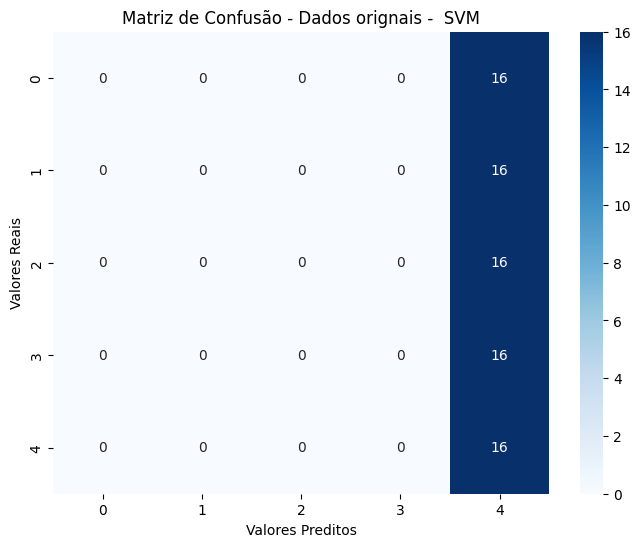

In [ ]:
cmsvm = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(8, 6))
sns.heatmap(cmsvm, annot=True, fmt='g', cmap='Blues')
plt.title('Matriz de Confusão - Dados orignais -  SVM')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

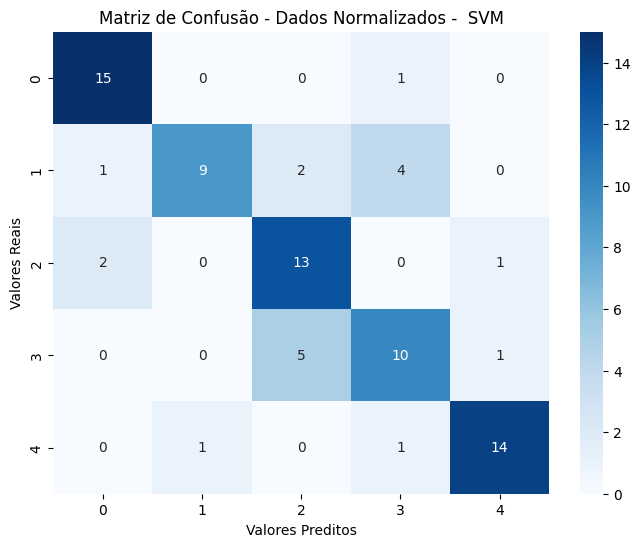

In [ ]:
cmsvm_normalizado = confusion_matrix(y_test, y_pred_svc_normalizado)

plt.figure(figsize=(8, 6))
sns.heatmap(cmsvm_normalizado, annot=True, fmt='g', cmap='Blues')
plt.title('Matriz de Confusão - Dados Normalizados -  SVM')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

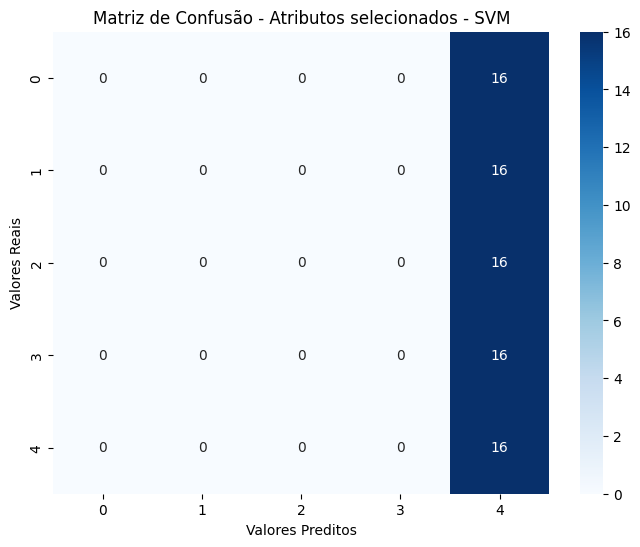

In [ ]:
cmsvm_selected = confusion_matrix(y_test, y_pred_svc_selected)

plt.figure(figsize=(8, 6))
sns.heatmap(cmsvm_selected, annot=True, fmt='g', cmap='Blues')
plt.title('Matriz de Confusão - Atributos selecionados - SVM')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

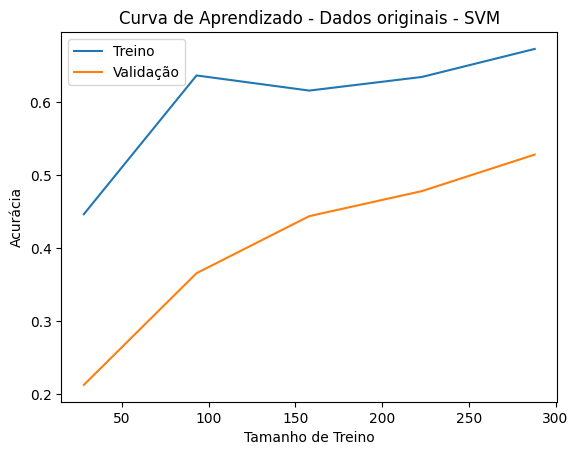

In [ ]:
train_sizes_SVM, train_scores_SVM, test_scores_SVM = learning_curve(best_svc, X_trainN, y_train, cv=cv_svm)

plt.plot(train_sizes_SVM, np.mean(train_scores_SVM, axis=1), label='Treino')
plt.plot(train_sizes_SVM, np.mean(test_scores_SVM, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Dados originais - SVM')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

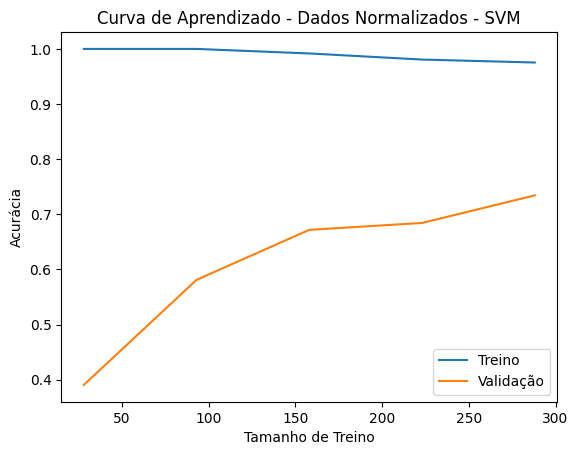

In [ ]:
train_sizes_SVM_normalizado, train_scores_SVM_normalizado, test_scores_SVM_normalizado = learning_curve(best_svc_normalizado, X_trainN, y_train, cv=cv_svm)

plt.plot(train_sizes_SVM_normalizado, np.mean(train_scores_SVM_normalizado, axis=1), label='Treino')
plt.plot(train_sizes_SVM_normalizado, np.mean(test_scores_SVM_normalizado, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Dados Normalizados - SVM')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

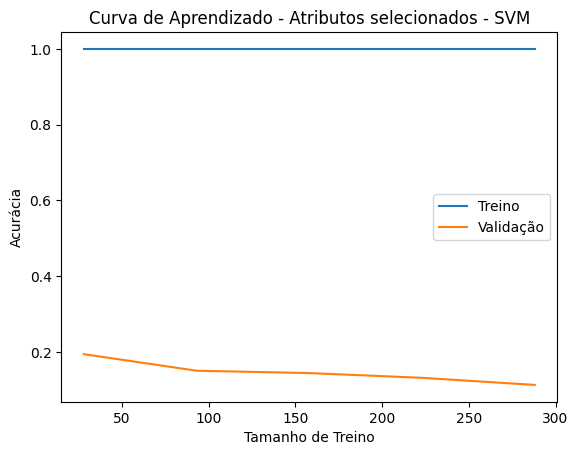

In [ ]:
train_sizes_SVM_selected, train_scores_SVM_selected, test_scores_SVM_selected = learning_curve(best_svc_selected, X_train_selected, y_train, cv=cv_svm)

plt.plot(train_sizes_SVM_selected, np.mean(train_scores_SVM_selected, axis=1), label='Treino')
plt.plot(train_sizes_SVM_selected, np.mean(test_scores_SVM_selected, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Atributos selecionados - SVM')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show

## Random Forest

In [ ]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

param_rf = {
    'model__n_estimators': [10, 50, 60, 70, 100],
    'model__max_depth': [1, 2, 3, 4],
    'model__min_samples_split': [2, 3, 4],
    'model__max_features': ['sqrt', 'log2']
}

cv_rf = KFold(n_splits=10, shuffle=True, random_state=42)

random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_rf,
    cv=cv_rf,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_rf_normalizado = RandomizedSearchCV(
    pipeline_rf,
    param_rf,
    cv=cv_rf,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_rf_selected = RandomizedSearchCV(
    pipeline_rf,
    param_rf,
    cv=cv_rf,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
random_search_rf.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [1, 2, 3, 4],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_split': [2, 3, 4],
                                        'model__n_estimators': [10, 50, 60, 70,
                                                                100]},
                   random_state=42, verbose=2)

In [ ]:
random_search_rf_normalizado.fit(X_trainN, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [1, 2, 3, 4],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_split': [2, 3, 4],
                                        'model__n_estimators': [10, 50, 60, 70,
                                                                100]},
                   random_state=42, verbose=2)

In [ ]:
random_search_rf_selected.fit(X_train_selected, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [1, 2, 3, 4],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_split': [2, 3, 4],
                                        'model__n_estimators': [10, 50, 60, 70,
                                                                100]},
                   random_state=42, verbose=2)

In [ ]:
print("Melhores parâmetros:", random_search_rf.best_params_)
print("Melhor score (validação cruzada):", random_search_rf.best_score_)

Melhores parâmetros: {'model__n_estimators': 60, 'model__min_samples_split': 2, 'model__max_features': 'log2', 'model__max_depth': 4}
Melhor score (validação cruzada): 0.684375


In [ ]:
print("Melhores parâmetros com normalização:", random_search_rf_normalizado.best_params_)
print("Melhor score (validação cruzada) com normalização:", random_search_rf_normalizado.best_score_)

Melhores parâmetros com normalização: {'model__n_estimators': 60, 'model__min_samples_split': 2, 'model__max_features': 'log2', 'model__max_depth': 4}
Melhor score (validação cruzada) com normalização: 0.68125


In [ ]:
print("Melhores parâmetros com atributos selecionados:", random_search_rf_selected.best_params_)
print("Melhor score (validação cruzada) com atributos selecionados:", random_search_rf_selected.best_score_)

Melhores parâmetros com atributos selecionados: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__max_features': 'sqrt', 'model__max_depth': 3}
Melhor score (validação cruzada) com atributos selecionados: 0.6125


In [ ]:
best_rf = random_search_rf.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
y_train_rf = best_rf.predict(X_train)

In [ ]:
best_rf_normalizado = random_search_rf_normalizado.best_estimator_
best_rf_normalizado.fit(X_trainN, y_train)
y_pred_rf_normalizado = best_rf_normalizado.predict(X_testN)
y_train_rf_normalizado = best_rf_normalizado.predict(X_trainN)

In [ ]:
best_rf_selected = random_search_rf_selected.best_estimator_
best_rf_selected.fit(X_train_selected, y_train)
y_pred_rf_selected = best_rf_selected.predict(X_test_selected)
y_train_rf_selected = best_rf_selected.predict(X_train_selected)

# Dados sem normalização

In [ ]:
print("Acurácia de treino RF:", accuracy_score(y_train, y_train_rf))
print("Acurácia de teste RF:",accuracy_score(y_test, y_pred_rf))
print("F1 Score de teste RF:", f1_score(y_test, y_pred_rf, average='weighted'))
print("Precisão de teste RF:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall de teste RF:", recall_score(y_test, y_pred_rf, average='weighted'))
print(classification_report(y_test, y_pred_rf))

Acurácia de treino RF: 0.86875
Acurácia de teste RF: 0.7125
F1 Score de teste RF: 0.7035521374624443
Precisão de teste RF: 0.7248805704099821
Recall de teste RF: 0.7125
              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78        16
         1.0       0.92      0.69      0.79        16
         2.0       0.67      0.62      0.65        16
         3.0       0.64      0.44      0.52        16
         4.0       0.76      0.81      0.79        16

    accuracy                           0.71        80
   macro avg       0.72      0.71      0.70        80
weighted avg       0.72      0.71      0.70        80



# Dados com normalização

In [ ]:
print("Acurácia de treino RF, dados normalizados:", accuracy_score(y_train, y_train_rf_normalizado))
print("Acurácia de teste RF, dados normalizados:",accuracy_score(y_test, best_rf_normalizado.predict(X_testN)))
print("F1 Score de teste RF, dados normalizados:", f1_score(y_test, y_pred_rf_normalizado, average='weighted'))
print("Precisão de teste RF, dados normalizados:", precision_score(y_test, y_pred_rf_normalizado, average='weighted'))
print("Recall de teste RF, dados normalizados:", recall_score(y_test, y_pred_rf_normalizado, average='weighted'))
print(classification_report(y_test, y_pred_rf_normalizado))

Acurácia de treino RF, dados normalizados: 0.86875
Acurácia de teste RF, dados normalizados: 0.7125
F1 Score de teste RF, dados normalizados: 0.7035521374624443
Precisão de teste RF, dados normalizados: 0.7248805704099821
Recall de teste RF, dados normalizados: 0.7125
              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78        16
         1.0       0.92      0.69      0.79        16
         2.0       0.67      0.62      0.65        16
         3.0       0.64      0.44      0.52        16
         4.0       0.76      0.81      0.79        16

    accuracy                           0.71        80
   macro avg       0.72      0.71      0.70        80
weighted avg       0.72      0.71      0.70        80



# Dados com seleção de atributos

In [ ]:
print("Acurácia de treino RF, atributos selecionados:", accuracy_score(y_train, y_train_rf_selected))
print("Acurácia de teste RF, atributos selecionados:",accuracy_score(y_test, best_rf_selected.predict(X_test_selected)))
print("F1 Score de teste RF, atributos selecionados:", f1_score(y_test, y_pred_rf_selected, average='weighted'))
print("Precisão de teste RF, atributos selecionados:", precision_score(y_test, y_pred_rf_selected, average='weighted'))
print("Recall de teste RF, atributos selecionados:", recall_score(y_test, y_pred_rf_selected, average='weighted'))
print(classification_report(y_test, y_pred_rf_selected))

Acurácia de treino RF, atributos selecionados: 0.70625
Acurácia de teste RF, atributos selecionados: 0.675
F1 Score de teste RF, atributos selecionados: 0.6565583904686972
Precisão de teste RF, atributos selecionados: 0.6759532163742691
Recall de teste RF, atributos selecionados: 0.675
              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78        16
         1.0       0.83      0.62      0.71        16
         2.0       0.67      0.62      0.65        16
         3.0       0.56      0.31      0.40        16
         4.0       0.68      0.81      0.74        16

    accuracy                           0.68        80
   macro avg       0.68      0.68      0.66        80
weighted avg       0.68      0.68      0.66        80



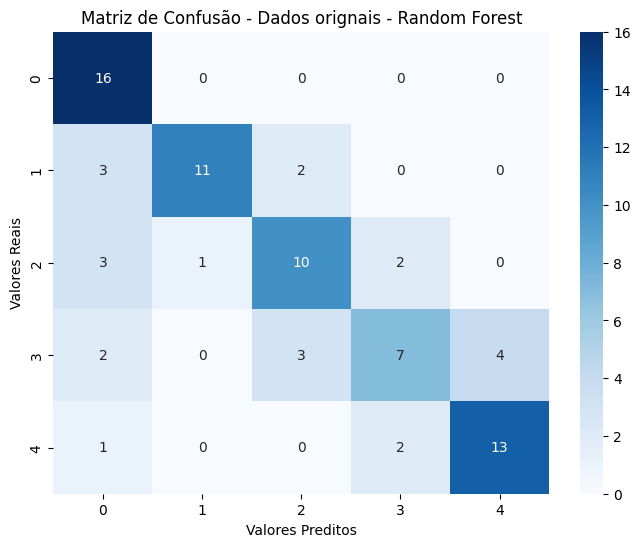

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Dados orignais - Random Forest')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

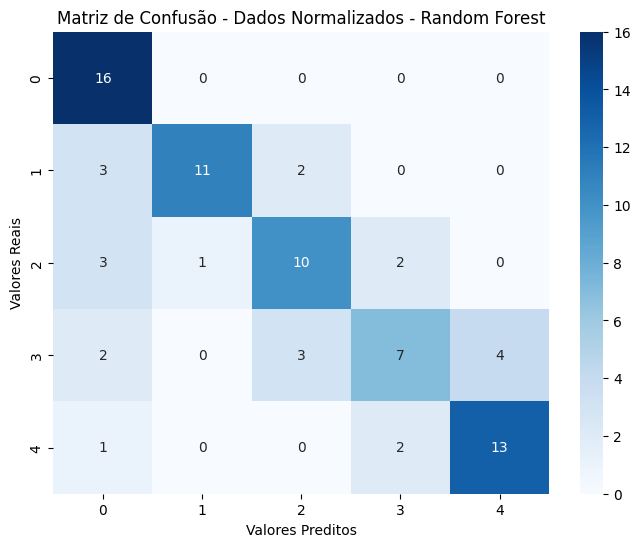

In [ ]:
cm_rf_normalizado = confusion_matrix(y_test, y_pred_rf_normalizado)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_normalizado, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Dados Normalizados - Random Forest')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

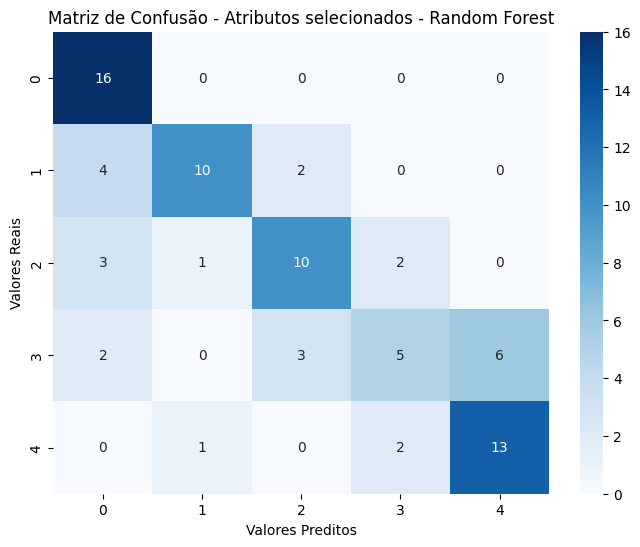

In [ ]:
cm_rf_selected = confusion_matrix(y_test, y_pred_rf_selected)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_selected, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Atributos selecionados - Random Forest')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

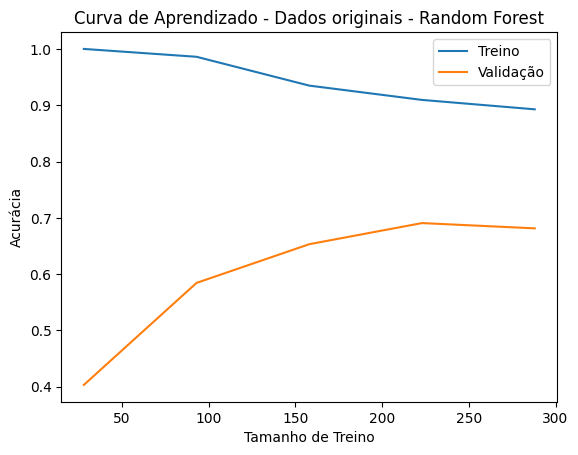

In [ ]:
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(best_rf, X_trainN, y_train, cv=cv_rf)

plt.plot(train_sizes_rf, np.mean(train_scores_rf, axis=1), label='Treino')
plt.plot(train_sizes_rf, np.mean(test_scores_rf, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Dados originais - Random Forest')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

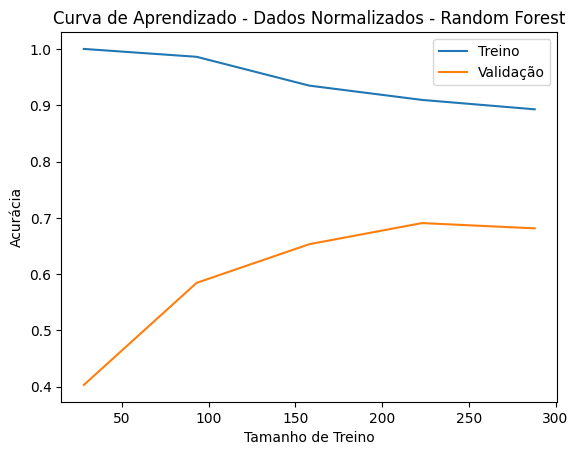

In [ ]:
train_sizes_rf_normalizado, train_scores_rf_normalizado, test_scores_rf_normalizado = learning_curve(best_rf_normalizado, X_trainN, y_train, cv=cv_rf)
plt.plot(train_sizes_rf_normalizado, np.mean(train_scores_rf_normalizado, axis=1), label='Treino')
plt.plot(train_sizes_rf_normalizado, np.mean(test_scores_rf_normalizado, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Dados Normalizados - Random Forest')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

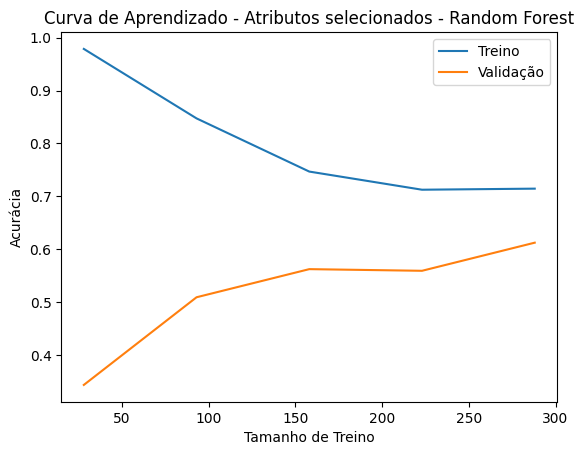

In [ ]:
train_sizes_DT_selected, train_scores_DT_selected, test_scores_DT_selected = learning_curve(best_rf_selected, X_train_selected, y_train, cv=cv_rf)

plt.plot(train_sizes_DT_selected, np.mean(train_scores_DT_selected, axis=1), label='Treino')
plt.plot(train_sizes_DT_selected, np.mean(test_scores_DT_selected, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Atributos selecionados - Random Forest')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()

## Multipercetron multicamadas - MLP

In [ ]:
pipeline_mlp = Pipeline([
    ('mlp', MLPClassifier(early_stopping=True, random_state=42))
])

parametros_mlp = {
    'mlp__hidden_layer_sizes': [(20,5),(50,), (75, 50), (100,), (100, 50)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__alpha': [0.01, 0.05, 0.1, 0.2],
    'mlp__learning_rate_init': [0.001, 0.005],
    'mlp__batch_size': [32, 64, 128, 256, 512],
    'mlp__max_iter': [2000, 3000],
    'mlp__learning_rate': ['adaptive'],
    'mlp__solver': ['adam'],
    'mlp__early_stopping': [True],
    'mlp__n_iter_no_change': [20, 30],
    }


cv_mlp = KFold(n_splits=10, shuffle=True, random_state=42)

random_search_mlp = RandomizedSearchCV(
    pipeline_mlp,
    parametros_mlp,
    cv=cv_mlp,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

random_search_mlp_normalizado = RandomizedSearchCV(
    pipeline_mlp,
    parametros_mlp,
    cv=cv_mlp,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

random_search_mlp_selected = RandomizedSearchCV(
    pipeline_mlp,
    parametros_mlp,
    cv=cv_mlp,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

In [ ]:
random_search_mlp.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('mlp',
                                              MLPClassifier(early_stopping=True,
                                                            random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'mlp__activation': ['relu', 'tanh',
                                                            'logistic'],
                                        'mlp__alpha': [0.01, 0.05, 0.1, 0.2],
                                        'mlp__batch_size': [32, 64, 128, 256,
                                                            512],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(20, 5),
                                                                    (50,),
                                                                    (75, 50),
                                                                    (100,),
                                                                    (100, 50)],
                                        'mlp__learning_rate': ['adaptive'],
                                        'mlp__learning_rate_init': [0.001,
                                                                    0.005],
                                        'mlp__max_iter': [2000, 3000],
                                        'mlp__n_iter_no_change': [20, 30],
                                        'mlp__solver': ['adam']},
                   random_state=42, verbose=2)

In [ ]:
random_search_mlp_normalizado.fit(X_trainN, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('mlp',
                                              MLPClassifier(early_stopping=True,
                                                            random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'mlp__activation': ['relu', 'tanh',
                                                            'logistic'],
                                        'mlp__alpha': [0.01, 0.05, 0.1, 0.2],
                                        'mlp__batch_size': [32, 64, 128, 256,
                                                            512],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(20, 5),
                                                                    (50,),
                                                                    (75, 50),
                                                                    (100,),
                                                                    (100, 50)],
                                        'mlp__learning_rate': ['adaptive'],
                                        'mlp__learning_rate_init': [0.001,
                                                                    0.005],
                                        'mlp__max_iter': [2000, 3000],
                                        'mlp__n_iter_no_change': [20, 30],
                                        'mlp__solver': ['adam']},
                   random_state=42, verbose=2)

In [ ]:
random_search_mlp_selected.fit(X_train_selected, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('mlp',
                                              MLPClassifier(early_stopping=True,
                                                            random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'mlp__activation': ['relu', 'tanh',
                                                            'logistic'],
                                        'mlp__alpha': [0.01, 0.05, 0.1, 0.2],
                                        'mlp__batch_size': [32, 64, 128, 256,
                                                            512],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(20, 5),
                                                                    (50,),
                                                                    (75, 50),
                                                                    (100,),
                                                                    (100, 50)],
                                        'mlp__learning_rate': ['adaptive'],
                                        'mlp__learning_rate_init': [0.001,
                                                                    0.005],
                                        'mlp__max_iter': [2000, 3000],
                                        'mlp__n_iter_no_change': [20, 30],
                                        'mlp__solver': ['adam']},
                   random_state=42, verbose=2)

In [ ]:
print("Melhores parâmetros:", random_search_mlp.best_params_)
print("Melhor score (validação cruzada):", random_search_mlp.best_score_)

Melhores parâmetros: {'mlp__solver': 'adam', 'mlp__n_iter_no_change': 20, 'mlp__max_iter': 3000, 'mlp__learning_rate_init': 0.001, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (50,), 'mlp__early_stopping': True, 'mlp__batch_size': 256, 'mlp__alpha': 0.05, 'mlp__activation': 'relu'}
Melhor score (validação cruzada): 0.21875


In [ ]:
print("Melhores parâmetros MLP, com normalização:", random_search_mlp_normalizado.best_params_)
print("Melhor score (validação cruzada) MLP:", random_search_mlp_normalizado.best_score_)

Melhores parâmetros MLP, com normalização: {'mlp__solver': 'adam', 'mlp__n_iter_no_change': 20, 'mlp__max_iter': 3000, 'mlp__learning_rate_init': 0.005, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (100, 50), 'mlp__early_stopping': True, 'mlp__batch_size': 32, 'mlp__alpha': 0.1, 'mlp__activation': 'tanh'}
Melhor score (validação cruzada) MLP: 0.5625


In [ ]:
print("Melhores parâmetros MLP, com atributos selecionados:", random_search_mlp_selected.best_params_)
print("Melhor score (validação cruzada) MLP:", random_search_mlp_selected.best_score_)

Melhores parâmetros MLP, com atributos selecionados: {'mlp__solver': 'adam', 'mlp__n_iter_no_change': 20, 'mlp__max_iter': 2000, 'mlp__learning_rate_init': 0.005, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (75, 50), 'mlp__early_stopping': True, 'mlp__batch_size': 64, 'mlp__alpha': 0.01, 'mlp__activation': 'tanh'}
Melhor score (validação cruzada) MLP: 0.23125


In [ ]:
best_mlp = random_search_mlp.best_estimator_
best_mlp.fit(X_train, y_train)
y_pred_mlp = best_mlp.predict(X_test)
y_pred_train_mlp = best_mlp.predict(X_train)

In [ ]:
best_mlp_normalizado = random_search_mlp_normalizado.best_estimator_
best_mlp_normalizado.fit(X_trainN, y_train)
y_pred_mlp_normalizado = best_mlp_normalizado.predict(X_testN)
y_pred_train_mlp_normalizado = best_mlp_normalizado.predict(X_trainN)

In [ ]:
best_mlp_selected = random_search_mlp_selected.best_estimator_
best_mlp_selected.fit(X_train_selected, y_train)
y_pred_mlp_selected = best_mlp_selected.predict(X_test_selected)
y_pred_train_mlp_selected = best_mlp_selected.predict(X_train_selected)

# Dados sem normalização

In [ ]:
print("Acurácia de treino MLP:", accuracy_score(y_train, y_pred_train_mlp))
print("Acurácia de teste MLP:", accuracy_score(y_test, y_pred_mlp))
print("F1 Score de teste MLP:", f1_score(y_test, y_pred_mlp, average='weighted'))
print("Precisão de teste MLP:", precision_score(y_test, y_pred_mlp, average='weighted'))
print("Recall de teste MLP:", recall_score(y_test, y_pred_mlp, average='weighted'))
print(classification_report(y_test, y_pred_mlp))

Acurácia de treino MLP: 0.2
Acurácia de teste MLP: 0.2
F1 Score de teste MLP: 0.06666666666666667
Precisão de teste MLP: 0.04
Recall de teste MLP: 0.2
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        16
         2.0       0.20      1.00      0.33        16
         3.0       0.00      0.00      0.00        16
         4.0       0.00      0.00      0.00        16

    accuracy                           0.20        80
   macro avg       0.04      0.20      0.07        80
weighted avg       0.04      0.20      0.07        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

# Dados normalizados

In [ ]:
print("Acurácia de treino MLP, dados normalizados:", accuracy_score(y_train, y_pred_train_mlp_normalizado))
print("Acurácia de teste MLP, dados normalizados:", accuracy_score(y_test, y_pred_mlp_normalizado))
print("F1 Score de teste MLP, dados normalizados:", f1_score(y_test, y_pred_mlp_normalizado, average='weighted'))
print("Precisão de teste MLP, dados normalizados:", precision_score(y_test, y_pred_mlp_normalizado, average='weighted'))
print("Recall de teste MLP, dados normalizados:", recall_score(y_test, y_pred_mlp_normalizado, average='weighted'))
print(classification_report(y_test, y_pred_mlp_normalizado))

Acurácia de treino MLP, dados normalizados: 0.828125
Acurácia de teste MLP, dados normalizados: 0.7375
F1 Score de teste MLP, dados normalizados: 0.7353616813294233
Precisão de teste MLP, dados normalizados: 0.7344117647058823
Recall de teste MLP, dados normalizados: 0.7375
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85        16
         1.0       0.73      0.69      0.71        16
         2.0       0.67      0.62      0.65        16
         3.0       0.62      0.62      0.62        16
         4.0       0.82      0.88      0.85        16

    accuracy                           0.74        80
   macro avg       0.73      0.74      0.74        80
weighted avg       0.73      0.74      0.74        80



In [ ]:
print("Acurácia de treino MLP:", accuracy_score(y_train, y_pred_train_mlp))
print("Acurácia de teste MLP:", accuracy_score(y_test, y_pred_mlp))
print("F1 Score de teste MLP:", f1_score(y_test, y_pred_mlp, average='weighted'))
print("Precisão de teste MLP:", precision_score(y_test, y_pred_mlp, average='weighted'))
print("Recall de teste MLP:", recall_score(y_test, y_pred_mlp, average='weighted'))
print(classification_report(y_test, y_pred_mlp))

Acurácia de treino MLP: 0.2
Acurácia de teste MLP: 0.2
F1 Score de teste MLP: 0.06666666666666667
Precisão de teste MLP: 0.04
Recall de teste MLP: 0.2
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.00      0.00      0.00        16
         2.0       0.20      1.00      0.33        16
         3.0       0.00      0.00      0.00        16
         4.0       0.00      0.00      0.00        16

    accuracy                           0.20        80
   macro avg       0.04      0.20      0.07        80
weighted avg       0.04      0.20      0.07        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

# Dados com seleção de atributos

In [ ]:
print("Acurácia de treino MLP, atributos selecionados:", accuracy_score(y_train, y_pred_train_mlp_selected))
print("Acurácia de teste MLP, atributos selecionados:", accuracy_score(y_test, y_pred_mlp_selected))
print("F1 Score de teste MLP, atributos selecionados:", f1_score(y_test, y_pred_mlp_selected, average='weighted'))
print("Precisão de teste MLP, atributos selecionados:", precision_score(y_test, y_pred_mlp_selected, average='weighted'))
print("Recall de teste MLP, atributos selecionados:", recall_score(y_test, y_pred_mlp_selected, average='weighted'))
print(classification_report(y_test, y_pred_mlp_selected))


Acurácia de treino MLP, atributos selecionados: 0.2
Acurácia de teste MLP, atributos selecionados: 0.2
F1 Score de teste MLP, atributos selecionados: 0.06666666666666667
Precisão de teste MLP, atributos selecionados: 0.04
Recall de teste MLP, atributos selecionados: 0.2
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.20      1.00      0.33        16
         2.0       0.00      0.00      0.00        16
         3.0       0.00      0.00      0.00        16
         4.0       0.00      0.00      0.00        16

    accuracy                           0.20        80
   macro avg       0.04      0.20      0.07        80
weighted avg       0.04      0.20      0.07        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

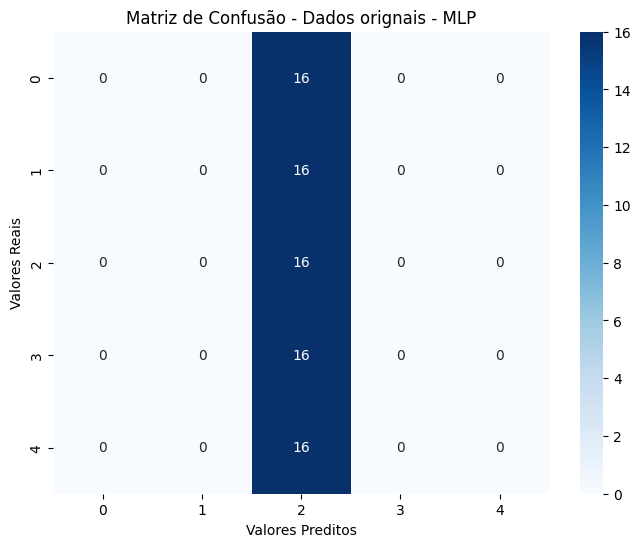

In [ ]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Dados orignais - MLP')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

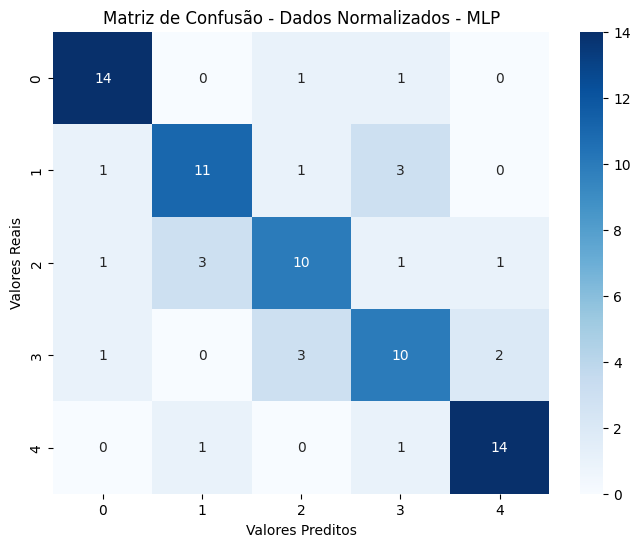

In [ ]:
cm_mlp_normalizado = confusion_matrix(y_test, y_pred_mlp_normalizado)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp_normalizado, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Dados Normalizados - MLP')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

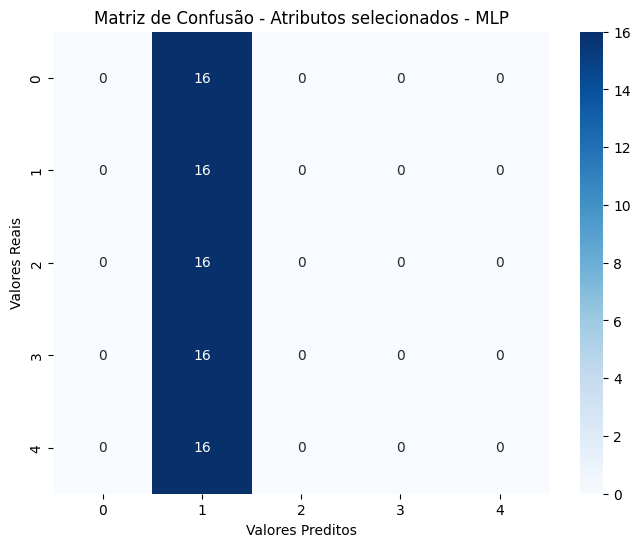

In [ ]:
cm_mlp_selected = confusion_matrix(y_test, y_pred_mlp_selected)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp_selected, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Atributos selecionados - MLP')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(best_rf, X_trainN, y_train, cv=cv_rf)

plt.plot(train_sizes_rf, np.mean(train_scores_rf, axis=1), label='Treino')
plt.plot(train_sizes_rf, np.mean(test_scores_rf, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Dados originais - Random Forest')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is go

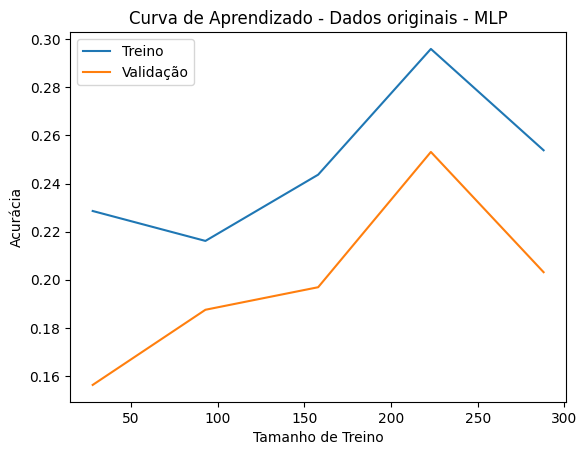

In [ ]:
train_sizes_mlp, train_scores_mlp, test_scores_mlp = learning_curve(best_mlp, X_trainN, y_train, cv=cv_mlp)

plt.plot(train_sizes_mlp, np.mean(train_scores_mlp, axis=1), label='Treino')
plt.plot(train_sizes_mlp, np.mean(test_scores_mlp, axis=1), label='Validação')
label='Curva de Aprendizado - Dados originais - MLP'
plt.title(label)
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

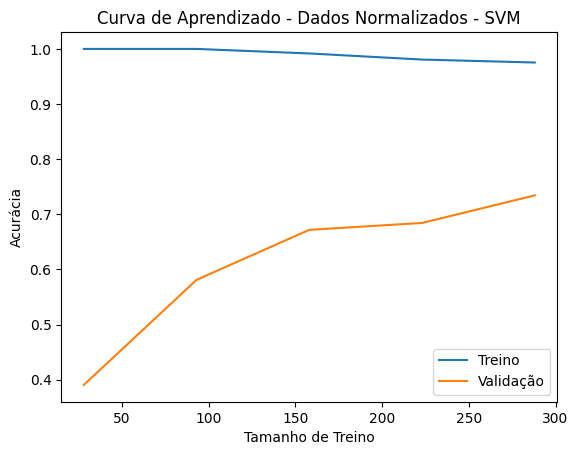

In [ ]:
train_sizes_SVM_normalizado, train_scores_SVM_normalizado, test_scores_SVM_normalizado = learning_curve(best_svc_normalizado, X_trainN, y_train, cv=cv_svm)
plt.plot(train_sizes_SVM_normalizado, np.mean(train_scores_SVM_normalizado, axis=1), label='Treino')
plt.plot(train_sizes_SVM_normalizado, np.mean(test_scores_SVM_normalizado, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Dados Normalizados - SVM')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

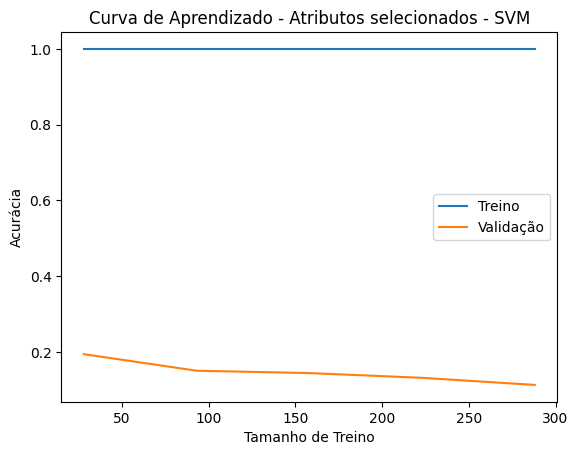

In [ ]:
train_sizes_SVM_selected, train_scores_SVM_selected, test_scores_SVM_selected = learning_curve(best_svc_selected, X_train_selected, y_train, cv=cv_svm)
plt.plot(train_sizes_SVM_selected, np.mean(train_scores_SVM_selected, axis=1), label='Treino')
plt.plot(train_sizes_SVM_selected, np.mean(test_scores_SVM_selected, axis=1), label='Validação')
plt.title('Curva de Aprendizado - Atributos selecionados - SVM')
plt.xlabel('Tamanho de Treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show

# Análise de métricas

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


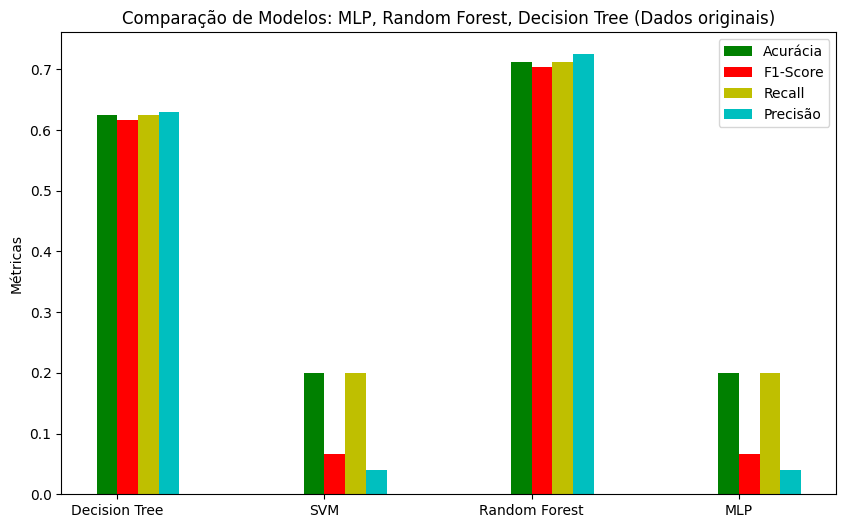

In [ ]:
modelos = ['Decision Tree', 'SVM','Random Forest','MLP']
# acuracia_treino= [accuracy_score(y_train, y_pred_train_tree), accuracy_score(y_train, y_train_svc), accuracy_score(y_train, y_train_rf), accuracy_score(y_train, y_pred_train_mlp)]
acuracia_teste = [accuracy_score(y_test, y_pred_tree), accuracy_score(y_test, y_pred_svc), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_mlp)]
recall_teste = [recall_score(y_test, y_pred_tree, average='weighted'), recall_score(y_test, y_pred_svc, average='weighted'), recall_score(y_test, y_pred_rf, average='weighted'), recall_score(y_test, y_pred_mlp, average='weighted')]
f1_scores = [f1_score(y_test, y_pred_tree, average='weighted'), f1_score(y_test, y_pred_svc, average='weighted'), f1_score(y_test, y_pred_rf, average='weighted'), f1_score(y_test, y_pred_mlp, average='weighted')]
precisao_teste = [precision_score(y_test, y_pred_tree, average='weighted'), precision_score(y_test, y_pred_svc, average='weighted'), precision_score(y_test, y_pred_rf, average='weighted'), precision_score(y_test, y_pred_mlp, average='weighted')]

x = np.arange(len(modelos))
width = 0.1

fig, ax = plt.subplots(figsize=(10, 6))
# ax.bar(x - width * 1.5, acuracia_treino, width, label='Acurácia (Treinamento)', color='b')
ax.bar(x - width / 2, acuracia_teste, width, label='Acurácia', color='g')
ax.bar(x + width / 2, f1_scores, width, label='F1-Score', color='r')
ax.bar(x + width * 1.5, recall_teste, width, label='Recall', color='y')
ax.bar(x + width * 2.5, precisao_teste, width, label='Precisão', color='c')

ax.set_ylabel('Métricas')
ax.set_title('Comparação de Modelos: MLP, Random Forest, Decision Tree (Dados originais)' )
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()

plt.show()


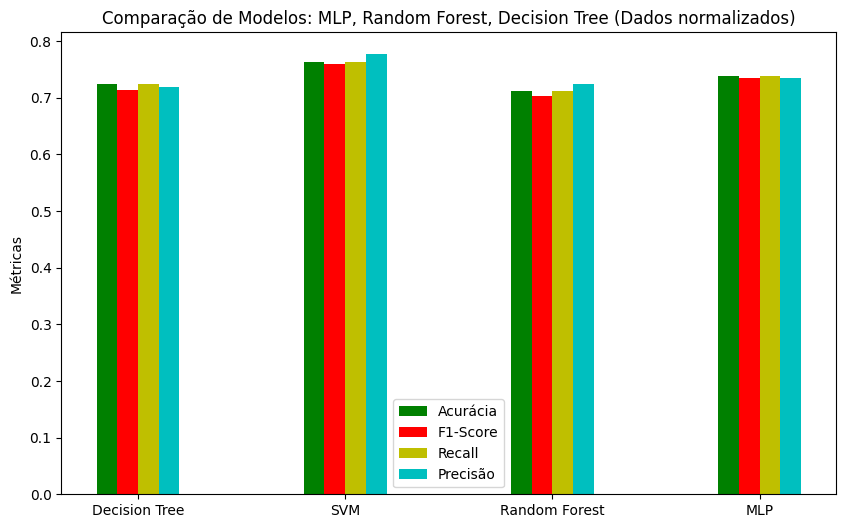

In [ ]:
modelos_normalizados = ['Decision Tree', 'SVM','Random Forest','MLP']
acuracia_teste_normalizado = [accuracy_score(y_test, y_pred_tree_normalizado), accuracy_score(y_test, y_pred_svc_normalizado), accuracy_score(y_test, y_pred_rf_normalizado), accuracy_score(y_test, y_pred_mlp_normalizado)]
recall_teste_normalizado = [recall_score(y_test, y_pred_tree_normalizado, average='weighted'), recall_score(y_test, y_pred_svc_normalizado, average='weighted'), recall_score(y_test, y_pred_rf_normalizado, average='weighted'), recall_score(y_test, y_pred_mlp_normalizado, average='weighted')]
f1_scores_normalizado = [f1_score(y_test, y_pred_tree_normalizado, average='weighted'), f1_score(y_test, y_pred_svc_normalizado, average='weighted'), f1_score(y_test, y_pred_rf_normalizado, average='weighted'), f1_score(y_test, y_pred_mlp_normalizado, average='weighted')]
precisao_teste_normalizado = [precision_score(y_test, y_pred_tree_normalizado, average='weighted'), precision_score(y_test, y_pred_svc_normalizado, average='weighted'), precision_score(y_test, y_pred_rf_normalizado, average='weighted'), precision_score(y_test, y_pred_mlp_normalizado, average='weighted')]

x_normalizado = np.arange(len(modelos_normalizados))
width = 0.1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_normalizado - width * 1.5, acuracia_teste_normalizado, width, label='Acurácia', color='g')
ax.bar(x_normalizado - width / 2, f1_scores_normalizado, width, label='F1-Score', color='r')
ax.bar(x_normalizado + width / 2, recall_teste_normalizado, width, label='Recall', color='y')
ax.bar(x_normalizado + width * 1.5, precisao_teste_normalizado, width, label='Precisão', color='c')

ax.set_ylabel('Métricas')
ax.set_title('Comparação de Modelos: MLP, Random Forest, Decision Tree (Dados normalizados)')
ax.set_xticks(x_normalizado)
ax.set_xticklabels(modelos_normalizados)
ax.legend()

plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


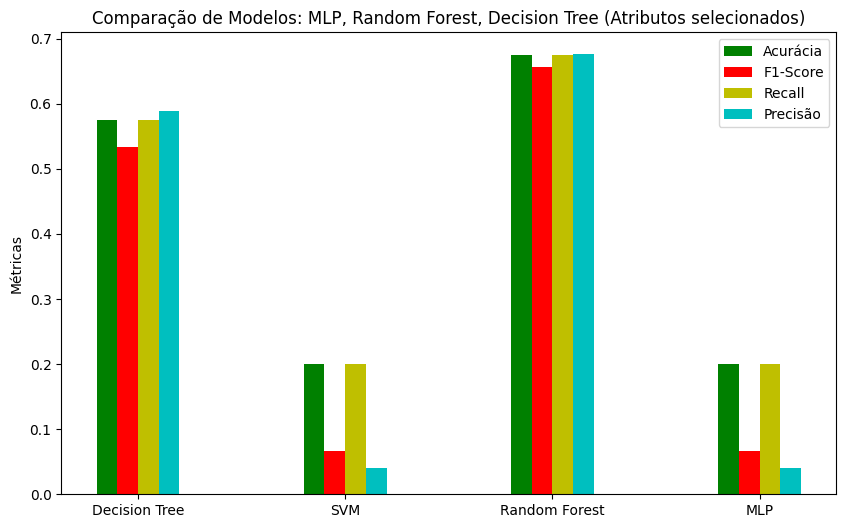

In [ ]:
modelos_selecionados = ['Decision Tree', 'SVM','Random Forest','MLP']
acuracia_teste_selecionados = [accuracy_score(y_test, y_pred_tree_selected), accuracy_score(y_test, y_pred_svc_selected), accuracy_score(y_test, y_pred_rf_selected), accuracy_score(y_test, y_pred_mlp_selected)]
recall_teste_selecionados = [recall_score(y_test, y_pred_tree_selected, average='weighted'), recall_score(y_test, y_pred_svc_selected, average='weighted'), recall_score(y_test, y_pred_rf_selected, average='weighted'), recall_score(y_test, y_pred_mlp_selected, average='weighted')]
f1_scores_selecionados = [f1_score(y_test, y_pred_tree_selected, average='weighted'), f1_score(y_test, y_pred_svc_selected, average='weighted'), f1_score(y_test, y_pred_rf_selected, average='weighted'), f1_score(y_test, y_pred_mlp_selected, average='weighted')]
precisao_teste_selecionados = [precision_score(y_test, y_pred_tree_selected, average='weighted'), precision_score(y_test, y_pred_svc_selected, average='weighted'), precision_score(y_test, y_pred_rf_selected, average='weighted'), precision_score(y_test, y_pred_mlp_selected, average='weighted')]

x_selecionados = np.arange(len(modelos_selecionados))
width = 0.1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_selecionados - width * 1.5, acuracia_teste_selecionados, width, label='Acurácia', color='g')
ax.bar(x_selecionados - width / 2, f1_scores_selecionados, width, label='F1-Score', color='r')
ax.bar(x_selecionados + width / 2, recall_teste_selecionados, width, label='Recall', color='y')
ax.bar(x_selecionados + width * 1.5, precisao_teste_selecionados, width, label='Precisão', color='c')

ax.set_ylabel('Métricas')
ax.set_title('Comparação de Modelos: MLP, Random Forest, Decision Tree (Atributos selecionados)')
ax.set_xticks(x_selecionados)
ax.set_xticklabels(modelos_selecionados)
ax.legend()

plt.show()

In [ ]:
cenarios = ['Original', 'Normalizado', 'Atributos Selecionado']
resultados = {
    'Decision Tree': {
        'Original': {'y_true': y_test, 'y_pred': y_pred_tree},
        'Normalizado': {'y_true': y_test, 'y_pred': y_pred_tree_normalizado},
        'Atributos Selecionado': {'y_true': y_test, 'y_pred': y_pred_tree_selected}
    },
    'SVM': {
        'Original': {'y_true': y_test, 'y_pred': y_pred_svc},
        'Normalizado': {'y_true': y_test, 'y_pred': y_pred_svc_normalizado},
        'Atributos Selecionado': {'y_true': y_test, 'y_pred': y_pred_svc_selected}
    },
    'Random Forest': {
        'Original': {'y_true': y_test, 'y_pred': y_pred_rf},
        'Normalizado': {'y_true': y_test, 'y_pred': y_pred_rf_normalizado},
        'Atributos Selecionado': {'y_true': y_test, 'y_pred': y_pred_rf_selected}
    },
    'MLP': {
        'Original': {'y_true': y_test, 'y_pred': y_pred_mlp},
        'Normalizado': {'y_true': y_test, 'y_pred': y_pred_mlp_normalizado},
        'Atributos Selecionado': {'y_true': y_test, 'y_pred': y_pred_mlp_selected}
    }
}


In [ ]:
metricas = {}

for modelo, cenarios_dict in resultados.items():
    metricas[modelo] = {}
    for cenario, dados in cenarios_dict.items():
        y_true = dados['y_true']
        y_pred = dados['y_pred']
        metricas[modelo][cenario] = {
            'acuracia': accuracy_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, average='weighted'),
            'recall': recall_score(y_true, y_pred, average='weighted'),
            'precisao': precision_score(y_true, y_pred, average='weighted')
        }


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

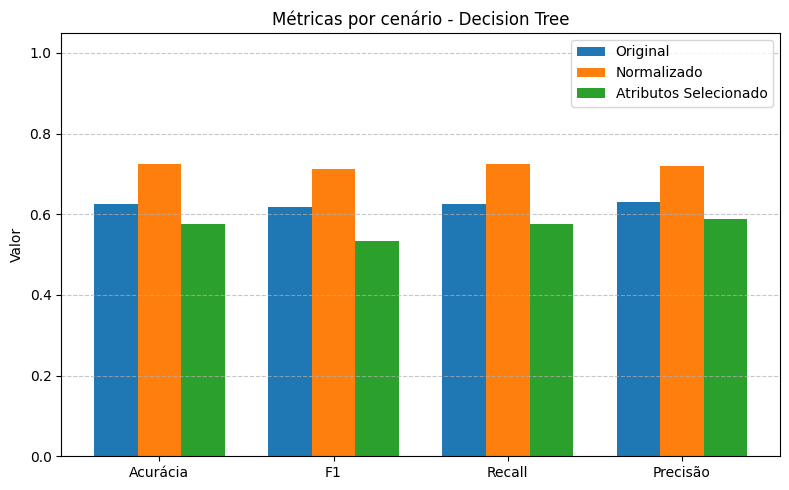

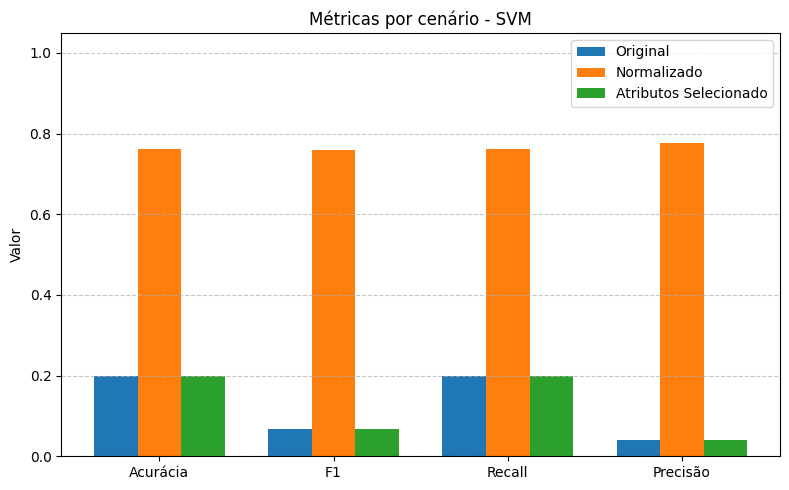

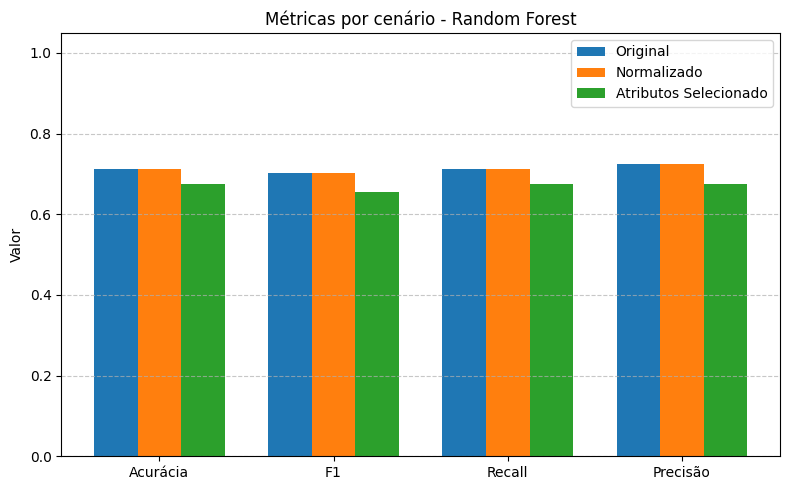

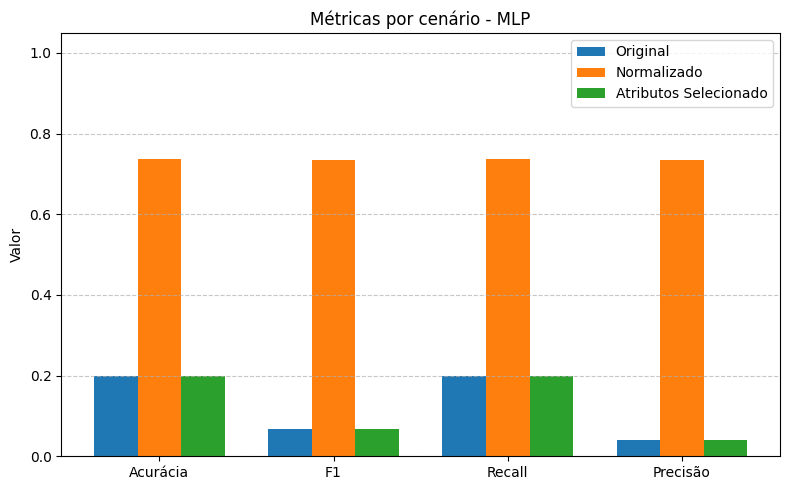

In [ ]:
def plot_modelo(modelo_nome):
    metrica_labels = ['acuracia', 'f1', 'recall', 'precisao']
    cenarios = list(metricas[modelo_nome].keys())

    valores = []
    for metrica in metrica_labels:
        valores.append([metricas[modelo_nome][c][metrica] for c in cenarios])

    x = np.arange(len(metrica_labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(8, 5))
    for i, cenario in enumerate(cenarios):
        ax.bar(x + i * width, [valores[j][i] for j in range(len(metrica_labels))], width, label=cenario)

    ax.set_ylabel('Valor')
    ax.set_title(f'Métricas por cenário - {modelo_nome}')
    ax.set_xticks(x + width)
    ax.set_xticklabels(['Acurácia', 'F1', 'Recall', 'Precisão'])
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


for modelo in modelos:
    plot_modelo(modelo)